In [1]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np

from collections import defaultdict
import math as math

In [2]:
meta_parameter = {
    'number of agents': 10,
    'number of resources': 5,
    'number of S scenario': 5,
    'number of T scenario': 10,
}

In [39]:
import random
def generate_scenario(meta_parameter):
    #S scenarios in second stage, T in extended stage
    n = meta_parameter['number of agents']

    S = meta_parameter['number of S scenario']
    T = meta_parameter['number of T scenario']
    scenario = {}

    pT=np.random.rand(S,T)
    pT=pT/sum(sum(pT))
    pT=pT.tolist()
    
    for j in range(S):
        scenario[j] = {}
        xS=[ random.uniform(0,0.6) for i in range(n)]
        scenario[j]['xi_1'] =  xS
        scenario[j]['prob'] = sum(pT[j])
        
        for k in range(T):
            xT=[ random.uniform(0,1) for i in range(n)]
            scenario[j][k]={'xi_2':xT,'prob':pT[j][k],'cond_prob':pT[j][k]/sum(pT[j])}
    return scenario 


scenario = generate_scenario(meta_parameter)


In [43]:
import pickle

with open('data', 'wb') as handle:
    pickle.dump(meta_parameter, handle)
    pickle.dump(scenario, handle)

In [5]:
print(scenario.keys())
print(scenario[0].keys())
print(scenario[0][0].keys())
print([scenario[i]['prob'] for i in range(5)])
print([scenario[0][i]['prob'] for i in range(10)])
print([scenario[0][i]['cond_prob'] for i in range(10)])

dict_keys([0, 1, 2, 3, 4])
dict_keys(['xi_1', 'prob', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
dict_keys(['xi_2', 'prob', 'cond_prob'])
[0.19811185973145418, 0.16478844962349634, 0.1853453388864705, 0.25495623842705667, 0.19679811333152236]
[0.01079029011451963, 0.013336330249867944, 0.023709809089490174, 0.020275812208000014, 0.018509918225692777, 0.03429533619077431, 0.033258264154168465, 0.005572435132736774, 0.027671299276135024, 0.010692365090069057]
[0.05446564445534029, 0.06731717257081776, 0.11967889818221605, 0.1023452721885727, 0.09343165144572091, 0.17311096992003677, 0.16787618974073998, 0.028127721077831264, 0.1396751275448335, 0.05397135287389073]


In [3]:
import pickle
with open('data', 'rb') as handle:
    meta_parameter = pickle.load(handle)
    scenario = pickle.load(handle)

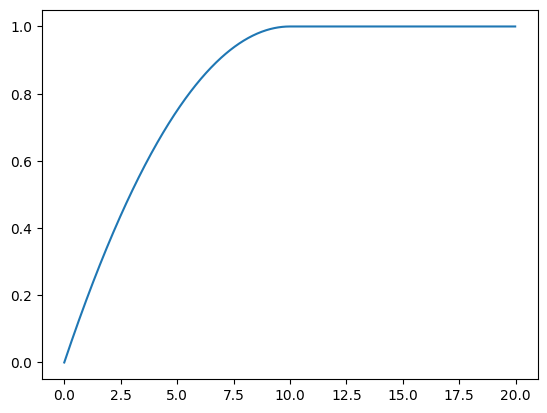

In [4]:
import numpy as np 
def evaluation(x, alpha):
    if (x<=alpha/2):
        return 4*((x/alpha) - (x/alpha)**2)
    else:
        return 1

import matplotlib.pyplot as plt


x = np.arange(0,20,0.025)
y = np.array([ evaluation(_,20) for _ in x])
plt.figure()
plt.plot(x, y, color='tab:blue')
plt.show()

Solving the problem with stochastic dominant constraints

If benchmark is none, then solve the risk-neutral problem

In [33]:
from gurobipy import quicksum as qsum

def subproblem(x_s, meta_parameter, scenario_s, bm_s = None):
    n = meta_parameter['number of agents']
    K = meta_parameter['number of resources']

    S = meta_parameter['number of S scenario']
    T = meta_parameter['number of T scenario']
    
    alpha = 2*K
    reallo_cost = 0.01
    
    w_s = sum(evaluation(scenario_s['xi_1'][i]*x_s[i], alpha) for i in range(n))
    
    scenario_extended = {}

    for t in range(T):
        scenario_extended[t] = [scenario_s[t]['xi_2'][i]*(1-scenario_s['xi_1'][i])\
             for i in range(n)]
        
    prob_extended_list = [ scenario_s[j]['cond_prob'] for j in range(T)]

    sp = gp.Model("subproblem")
    
    z = sp.addVars(n,n, vtype=GRB.CONTINUOUS, name="z", lb=list(np.zeros((n,n)))) #reallocate
    y = sp.addVars(n,   vtype=GRB.CONTINUOUS, name="y", lb=list(np.zeros(n))) #new resources

    
    # conditional probability of extended stage, conditioning on S
    extended_obj = {}
    for t in range(T):
        extended_obj[t] = qsum(4*((scenario_extended[t][i]*y[i]/alpha) - \
                                    (scenario_extended[t][i]*y[i]/alpha)**2)  for i in range(n)) 
    extended_obj_exp = qsum(extended_obj[t]*prob_extended_list[t] for t in range(T))

    obj = w_s + extended_obj_exp  - reallo_cost*z.sum()
    sp.setObjective( obj, GRB.MAXIMIZE)

    reallocate = sp.addConstrs( (y[i] == (1-scenario_s['xi_1'][i])*x_s[i] +\
                                     z.sum('*',i)-z.sum(i,'*') for i in range(n)), \
                                    name = 'reallocate')

    sp.setParam('OutputFlag', 0)
    sp.setParam('QCPDual', 1)
    sp.setParam('DualReductions', 0)

    max_it = 1e2
    it = 0

 
    if bm_s is None:
        sp.optimize()
        # print(sp.status)
        if sp.status == GRB.OPTIMAL:
            
            feas = 1
            
            lmbd = [reallocate[i].Pi for i in range(n)]
            
            cut_subdiff = [lmbd[i]*(1-scenario_s['xi_1'][i]) + 4*(1-2*(scenario_s['xi_1'][i]/alpha)*x_s[i])\
                *(scenario_s['xi_1'][i]/alpha) for i in range(n)]
            
            obj_val = obj.getValue()
            val_t = [(w_s - reallo_cost*z.sum() + extended_obj[t]).getValue() for t in range(T)]
            return cut_subdiff, feas, obj_val, val_t, None
        else:
            raise Exception('risk neutral subproblem is infeasible')
    # if given a benchmark, then add in event cut 
    else:
        print('MS_cvx_event_cut')
        value_list_b = [ bm_s['r_s'] + bm_s[t]['r_t'] for t in range(T) ]
        # short_fall_b = {}
        # for t in range(T):
        #     short_fall_b[t] =  sum(bm_s[tt]['cond_prob']*max(value_list_b[t] - value_list_b[tt],0) \
        #                                                 for tt in range(T))
        shtf = sp.addVars(T, T, vtype=GRB.CONTINUOUS, name="shtf", lb=list(np.zeros((T,T))))
        shtf_def = sp.addConstrs( (shtf[(t, tt)] >= value_list_b[t] - w_s +\
             reallo_cost*z.sum()- extended_obj[tt] for t in range(T)\
                 for tt in range(T)), name = 'shtf_def')
        
        #Write order constraint as T ineq constr: E[(eta-X)+]<=E[(eta-Y)+], for eta=Y(\omega_1), ...
        
        #expected shortfall of benchmark: E[(eta_t - Y)+]
        exp_shtf_bm = [sum(prob_extended_list[tt] * max(0,value_list_b[t]-value_list_b[tt]) for tt in range(T)) for t in range(T)]
        
        
        ord_constr = sp.addConstrs( (qsum(prob_extended_list[tt]*shtf[(t,tt)] for tt in range(T)) \
                                    <= exp_shtf_bm[t] for t in range(T)), name = 'ord_constr')
        sp.optimize()
        # print(sp.display())
        if sp.status == GRB.OPTIMAL:

            gap = {}
            for t in range(T):
                for tt in range(T):
                    gap[t,tt] =  max(0,(value_list_b[t] - w_s + reallo_cost*z.sum()- extended_obj[tt]).getValue())
            print(gap)

            lmbd = [reallocate[i].Pi for i in range(n)]
            
            cut_subdiff = [lmbd[i]*(1-scenario_s['xi_1'][i]) + 4*(1-2*(scenario_s['xi_1'][i]/alpha)*x_s[i])\
                *(scenario_s['xi_1'][i]/alpha) for i in range(n)]
            
            obj_val = obj.getValue()
            val_t = [(w_s - reallo_cost*z.sum() + extended_obj[t]).getValue() for t in range(T)]

            return cut_subdiff, 1, obj_val, val_t,gap

                
        elif (sp.status == GRB.INFEASIBLE):
            
            sp.remove(reallocate)
            
            u = sp.addVars(n, vtype=GRB.CONTINUOUS, name="u", lb = -GRB.INFINITY)
            u_abs = sp.addVars(n, vtype=GRB.CONTINUOUS, name="u_abs",lb = 0)
            
            reallocate_again = sp.addConstrs( (u[i] + y[i] == (1-scenario_s['xi_1'][i])*x[i] +\
                                             z.sum('*',i)-z.sum(i,'*') for i in range(n)),\
                                                name = 'reallocate_again')
            
            abs_of_u = sp.addConstrs( (u[i] <= u_abs[i] for i in range(n)) , name = 'abs_of_u')
            abs_of_u_ = sp.addConstrs( (-u[i] <= u_abs[i] for i in range(n)) , name = 'abs_of_u_')
            
            obj_feas = qsum(u_abs)
            sp.setObjective(obj_feas, GRB.MINIMIZE)
            
            sp.optimize()
            if sp.status != GRB.OPTIMAL:
                raise Exception(f'feasible subproblem status code {sp.status}')

            cut_val = obj_feas.getValue()
            # cut_val = sp.ObjVal
            
            lmbd = [reallocate_again[i].Pi for i in range(n)]
            
            
            cut_subdiff = [lmbd[i]*(1-scenario_s['xi_1'][i]) +\
                    4*(1-2*(scenario_s['xi_1'][i]/alpha)*x[i])*(scenario_s['xi_1'][i]/alpha) for i in range(n)]
            
            return cut_subdiff, 0, cut_val, [-float('inf') for i in range(T)], None
        raise Exception(f'subproblem stopped due to statuse code {sp.status})')

In [37]:
bm = generate_bm(meta_parameter,scenario, val_s, val_t, scale=1)
print(subproblem( x, meta_parameter, scenario[0], bm[0]))

([0.36130901792779996, 0.5205191174837906, 0.49613775696670537], 1, 1.1530617661879758, [0.4551107621713219, 0.5599892995849055, 0.34317934076359213], {(0, 0): 0.047452392044163766, (0, 1): 0.2585730525392509, (0, 2): 0.047381351685457214, (1, 0): 0.13318212206128222, (1, 1): 0.44941838383113253, (1, 2): 0.11271751874648472, (2, 0): 7.759905466863634e-10, (2, 1): 9.914577988567859e-10, (2, 2): 1.7935891164465632e-10})


In [21]:
def masterproblem(x_start, meta_parameter, scenario, bm = None, max_it = 1e2):
    n = meta_parameter['number of agents']
    K = meta_parameter['number of resources']

    S = meta_parameter['number of S scenario']
    T = meta_parameter['number of T scenario']
    
    # if bm is none we consider risk-neutral solution
    if bm is None:
        bm = [None for i in range(S)]
    
    # nvm
    # assert S == len(scenario)-1, f" S not equal:"
    # assert T == len(scenario[0][0]), f"T not equal"

    prob_s = [ scenario[s]['prob'] for s in range(S)]
    
    prob_s_dict = dict([(s, prob_s[s]) for s in range(S)])
    
    mp=gp.Model("masterproblem")
    
    x = mp.addVars(n, vtype=GRB.CONTINUOUS, name="x", lb=list(np.zeros(n)))
    v = mp.addVars(S, vtype=GRB.CONTINUOUS, name="v", lb=-GRB.INFINITY, ub=[10 for i in range(S)])
    
    v_exp = v.prod(prob_s_dict)
    
    mp.setObjective(v_exp, GRB.MAXIMIZE)
    
    mp.addConstr( qsum(x) <= K )
    
    mp.setParam('OutputFlag', 0)
    
    
    it = 0 #iteration
    
    x_it = x_start #n*1 vector
    cuts = {}
    i_cut = 0
    while (it<max_it):
        print('it', it)
        optm_sec_stage = [0 for i in range(S)]
        
        feas_sec_stage = True
        
        v_t = []
        #obj cut & feas cut
        for s in range(S):
            print('S',s)
            subdiff, feas, val, val_t,gap = subproblem(x_it, meta_parameter, scenario[s], bm_s=bm[s])

            if feas==1:
                subdiff_dict = dict([(i,subdiff[i]) for i in range(n)])
                cuts[i_cut] = mp.addConstr( v[s] <= val + x.prod(subdiff_dict) - sum(subdiff[i]*x_it[i]\
                     for i in range(n)) )
                optm_sec_stage[s] = val
                # print("\n add a objective cut for scenario", 'it:', it, 'scenario' ,s, "\n")
                
            else:
                subdiff_dict = dict([(i,subdiff[i]) for i in range(n)])
                cuts[i_cut] = mp.addConstr( val + x.prod(subdiff_dict) - sum(subdiff[i]*x_it[i] for i in range(n)) <= 0 )
                
                feas_sec_stage = False
                optm_sec_stage[s] = -float('inf')
                print("\n add a feasbility cut for scenario", 'it:', it, 'scenario' ,s, "\n")
            i_cut += 1
            v_t.append(val_t)
        
        mp.optimize()
        # print(mp.display())
        if mp.status != GRB.OPTIMAL:
            raise Exception(f'master problem status code {mp.status}')
        x_it_ = x_it
        x_it = [x[i].x for i in range(n)]
        
        if feas_sec_stage == False:
            it = it + 1
            continue;
        if sum([abs(x_it_[i]-x_it[i]) for i in range(n)])<0.1:
            break
             
        
        stop_crit = sum(abs(optm_sec_stage[s]-v[s].X) for s in range(S))
        
        # print(optm_sec_stage)
        # print([v[s].x for s in range(S)])
        if ( stop_crit < 1e-5 ):
            break;    
            
        it = it + 1
       
    if it<max_it:
        print('iteration number runned', it)

        return x_it, [v[s].x for s in range(S)], v_t
    else:
        raise Exception('pre-mature as max iteration number reached at master problem')

In [51]:
# meta_parameter = {
#     'number of agents': 3,
#     'number of resources': 2,
#     'number of S scenario': 3,
#     'number of T scenario': 3,
# }
# scenario = generate_scenario(meta_parameter)
# with open('data', 'wb') as handle:
#     pickle.dump(meta_parameter, handle)
#     pickle.dump(scenario, handle)


In [34]:
def generate_x_start(meta_parameter):
    n = meta_parameter['number of agents']
    K = meta_parameter['number of resources']

    S = meta_parameter['number of S scenario']
    T = meta_parameter['number of T scenario']
    val = float(K-1)/float(n)
    return [ 0.5 for i in range(n)]
    
x_start = generate_x_start(meta_parameter)
print(x_start)
x, val_s, val_t = masterproblem(x_start, meta_parameter, scenario)
print(x)
print(val_s)

[0.5, 0.5, 0.5]
it 0
S 0
S 1
S 2
it 1
S 0
S 1
S 2
it 2
S 0
S 1
S 2
it 3
S 0
S 1
S 2
it 4
S 0
S 1
S 2
it 5
S 0
S 1
S 2
it 6
S 0
S 1
S 2
iteration number runned 6
[0.0, 1.1466626781930365, 0.8533373218069636]
[1.153158776385837, 1.3045435203731466, 1.1472492309879136]


In [53]:
def generate_bm(meta_parameter,scenario, val_s, val_t, scale = 1, shift = None):
    n = meta_parameter['number of agents']
    K = meta_parameter['number of resources']

    S = meta_parameter['number of S scenario']
    T = meta_parameter['number of T scenario']
    bm = {}
    for s in range(S):
        bm[s] = {}
        bm[s]['r_s'] = 0
        for t in range(T):
            bm[s][t] = {}
            bm[s][t]['cond_prob'] =  scenario[s][t]['cond_prob']
            tem = 0 if shift is None else shift[s]
            bm[s][t]['r_t'] = val_t[s][t] * scale  + tem
    return bm
bm = generate_bm(meta_parameter,scenario, val_s, val_t, scale=1)

In [66]:
from f2plot import F2_plot
bm_1 = generate_bm(meta_parameter,scenario, val_s, val_t, scale=0.98)
bm_1p5 = generate_bm(meta_parameter,scenario, val_s, val_t, scale=0.5)
x_ssd, val_s_ssd, val_t_ssd = masterproblem(x, meta_parameter, scenario,bm_1)
bm_ssd = generate_bm(meta_parameter,scenario, val_s_ssd, val_t_ssd, scale=1)
F2_plot(meta_parameter,source = bm_1, target = bm_ssd)

it 0
S 0
MS_cvx_event_cut
{(0, 0): 0, (0, 1): 0, (0, 2): 0.08726926568623582, (1, 0): 0.07815122407117023, (1, 1): 0, (1, 2): 0.19045062311217253, (2, 0): 0, (2, 1): 0, (2, 2): 0}
S 1
MS_cvx_event_cut
{(0, 0): 0, (0, 1): 0.5294691850738609, (0, 2): 0.10748414309315826, (1, 0): 0, (1, 1): 0, (1, 2): 0, (2, 0): 0, (2, 1): 0.3951243971895127, (2, 2): 0}
S 2
MS_cvx_event_cut
{(0, 0): 0, (0, 1): 0.1934378632041523, (0, 2): 0, (1, 0): 0, (1, 1): 0, (1, 2): 0, (2, 0): 0.10155655848404936, (2, 1): 0.31878649710918655, (2, 2): 0}
it 1
S 0
MS_cvx_event_cut

 add a feasbility cut for scenario it: 1 scenario 0 

S 1
MS_cvx_event_cut

 add a feasbility cut for scenario it: 1 scenario 1 

S 2
MS_cvx_event_cut
{(0, 0): 0, (0, 1): 0.2022234438094935, (0, 2): 0, (1, 0): 0, (1, 1): 0, (1, 2): 0, (2, 0): 0.10167005479071557, (2, 1): 0.32757207771452745, (2, 2): 0}
it 2
S 0
MS_cvx_event_cut

 add a feasbility cut for scenario it: 2 scenario 0 

S 1
MS_cvx_event_cut

 add a feasbility cut for scenario it: 

Exception: master problem status code 3

In [38]:
x_ssd,x

([0.0, 1.1733424009677023, 0.8266575990322977],
 [0.0, 1.1466626781930365, 0.8533373218069636])

In [39]:
from gurobipy import quicksum as qsum

def subproblem_shift(x_s, meta_parameter, scenario_s, bm_s, penalty_shit = 0.01):
    n = meta_parameter['number of agents']
    K = meta_parameter['number of resources']

    S = meta_parameter['number of S scenario']
    T = meta_parameter['number of T scenario']
    
    alpha = 2*K
    reallo_cost = 0.01
    penalty_shit = 0.01

    w_s = sum(evaluation(scenario_s['xi_1'][i]*x_s[i], alpha) for i in range(n))
    scenario_extended = {}
    for t in range(T):
        scenario_extended[t] = [scenario_s[t]['xi_2'][i]*(1-scenario_s['xi_1'][i]) for i in range(n)]
        
    prob_extended_list = [ scenario_s[j]['cond_prob'] for j in range(T)]

    sp = gp.Model("subproblem")
    
    z = sp.addVars(n,n, vtype=GRB.CONTINUOUS, name="z", lb=list(np.zeros((n,n)))) #reallocate
    y = sp.addVars(n,   vtype=GRB.CONTINUOUS, name="y", lb=list(np.zeros(n))) #new resources
    # shift = sp.addVar( vtype=GRB.CONTINUOUS, name="shift", lb=0)
    shift = sp.addVar(vtype=GRB.CONTINUOUS, name="shift", lb=-GRB.INFINITY)

    
    #conditional probability of extended stage, conditioned by scenario s at second stage
    extended_obj = {}
    extended_obj_shift = {}
    for t in range(T):
        extended_obj[t] = qsum(4*((scenario_extended[t][i]*y[i]/alpha) - \
                                    (scenario_extended[t][i]*y[i]/alpha)**2)  for i in range(n))
        extended_obj_shift[t] = shift + qsum(4*((scenario_extended[t][i]*y[i]/alpha) - \
                                    (scenario_extended[t][i]*y[i]/alpha)**2)  for i in range(n)) 
    extended_obj_exp = qsum(extended_obj[t]*prob_extended_list[t] for t in range(T))

    obj = w_s- penalty_shit*shift + extended_obj_exp  - reallo_cost*z.sum()
    sp.setObjective( obj, GRB.MAXIMIZE)

    reallocate = sp.addConstrs( (y[i] == ((1-scenario_s['xi_1'][i])*x_s[i] + z.sum('*',i)-z.sum(i,'*')) for i in range(n)), \
                                    name = 'reallocate')

    sp.setParam('OutputFlag', 0)
    sp.setParam('QCPDual', 1)
    sp.setParam('BarQCPConvTol', 1e-7)
    # tolerance = 1e-2

    max_it = 1e2
    it = 0

    value_list_b = [ bm_s['r_s'] + bm_s[t]['r_t'] for t in range(T) ]
    shtf = sp.addVars(T, T, vtype=GRB.CONTINUOUS, name="shtf", lb=list(np.zeros((T,T))))
    shtf_def = sp.addConstrs( (shtf[t, tt] >= value_list_b[t] -w_s - extended_obj_shift[tt] + reallo_cost*z.sum() \
              for tt in range(T) for t in range(T)), name = 'shtf_def')
    
    exp_shtf_bm = [qsum(prob_extended_list[tt] * max(0,value_list_b[t]-value_list_b[tt])\
         for tt in range(T)) for t in range(T)]
    
    prob_extended_edit = dict( [((t,tt),prob_extended_list[tt])\
         for tt in range(T) for t in range(T)] )
    
    ord_constr = sp.addConstrs( (shtf.prod(prob_extended_edit, t, '*') \
        <= exp_shtf_bm[t] for t in range(T)), name = 'ord_constr' )
    
    sp.optimize()
    try:
        lmbd = [reallocate[i].Pi for i in range(n)]
            
        cut_subdiff = [lmbd[i]*(1-scenario_s['xi_1'][i]) + 4*(1-2*(scenario_s['xi_1'][i]/alpha)*x_s[i])\
            *(scenario_s['xi_1'][i]/alpha) for i in range(n)]
        
        obj_val = obj.getValue()
        val_t = [(w_s - reallo_cost*z.sum() + extended_obj[t]).getValue() for t in range(T)]

        return cut_subdiff, 1, obj_val, val_t, shift.X
    except:
        raise Exception(f'subproblem event cut status code {sp.status})')
  

In [40]:
def masterproblem_shift(x_start, meta_parameter, scenario, bm, \
                                    max_it = 1e2, penalty_shit = 0.01):
    n = meta_parameter['number of agents']
    K = meta_parameter['number of resources']

    S = meta_parameter['number of S scenario']
    T = meta_parameter['number of T scenario']

    if bm is None:
        bm = [None for i in range(S)]
    

    prob_s = [ scenario[s]['prob'] for s in range(S)]
    
    prob_s_dict = dict([(s, prob_s[s]) for s in range(S)])
    
    mp=gp.Model("masterproblem")
    
    x = mp.addVars(n, vtype=GRB.CONTINUOUS, name="x", lb=list(np.zeros(n)))
    v = mp.addVars(S, vtype=GRB.CONTINUOUS, name="v", lb=-GRB.INFINITY, ub=[100 for i in range(n)])
    
    v_exp = v.prod(prob_s_dict)
    
    mp.setObjective(v_exp, GRB.MAXIMIZE)
    
    mp.addConstr( x.sum() <= K )
    
    mp.setParam('OutputFlag', 0)
    
    it = 0 #iteration
    
    x_it = x_start #n*1 vector
    cuts = {}
    i_cut = 0
    shift = [0 for i in range(S)]
    while (it<max_it):
        # print('it', it)
        optm_sec_stage = [0 for i in range(S)]
        
        feas_sec_stage = True
        
        v_t = []
        #obj cut & feas cut
        for s in range(S):
            # print('S',s)
            subdiff, feas, val, val_t, shift[s] = subproblem_shift(x_it, meta_parameter, scenario[s], 
                                                                bm[s], penalty_shit)

            if feas==1:
                subdiff_dict = dict([(i,subdiff[i]) for i in range(n)])
                cuts[i_cut] = mp.addConstr( v[s] <= val + x.prod(subdiff_dict) - sum(subdiff[i]*x_it[i]\
                     for i in range(n)) )
                optm_sec_stage[s] = val
                # print("\n add a objective cut for scenario", 'it:', it, 'scenario' ,s, "\n")
                
                i_cut += 1
            elif feas==0:
                subdiff_dict = dict([(i,subdiff[i]) for i in range(n)])
                mp.addConstr( val + x.prod(subdiff_dict) - sum(subdiff[i]*x_it[i] for i in range(n)) <= 0 )
                
                feas_sec_stage = False
                optm_sec_stage[s] = -float('inf')
                print("\n add a feasbility cut for scenario", 'it:', it, 'scenario' ,s, "\n")
            v_t.append(val_t)
        
        mp.optimize()
        # print(mp.display())
        if mp.status != GRB.OPTIMAL:
            raise Exception(f'master problem status code {mp.status}')
        x_it = [x[i].x for i in range(n)]
        
        if feas_sec_stage == False:
            it = it + 1
            continue
             
        
        stop_crit = sum(abs(optm_sec_stage[s]-v[s].x) for s in range(S))
        
        # print(optm_sec_stage)
        # print([v[s].x for s in range(S)])
        if ( stop_crit < 1e-3 ):
            break;    
            
        it = it + 1
    if it<max_it:
        return x_it, [v[s].x for s in range(S)], v_t, shift
    else:
        print('pre-mature as max iteration number reached')
        return x_it, [v[s].x for s in range(S)], v_t, shift

In [63]:
print('start point',x_start)
bm = generate_bm(meta_parameter,scenario, val_s, val_t, scale=1.5, shift = None)
x_shift, val_s_shift, val_t_shift,shift = masterproblem_shift(x_start, meta_parameter, scenario,bm, max_it= 100, penalty_shit=.01)
print(x)
print(x_shift)

print(shift)

start point [0.5, 0.5, 0.5]
[0.0, 1.1466626781930365, 0.8533373218069636]
[0.0, 1.1511448059199478, 0.8488551940800522]
[0.5749338133225198, 0.6541411152257196, 0.5707946200637105]


In [64]:
bm_shift = generate_bm(meta_parameter,scenario, val_s_shift, val_t_shift, scale=1)
bm_shift_y = generate_bm(meta_parameter,scenario, val_s, val_t, scale=1.5, shift = [-tem for tem in shift])

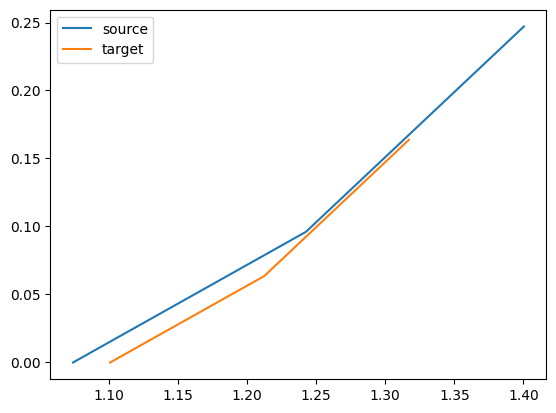

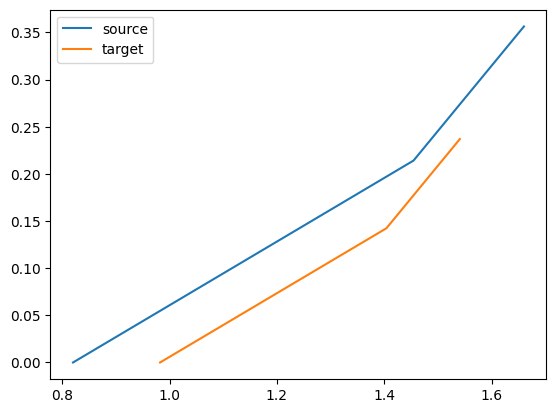

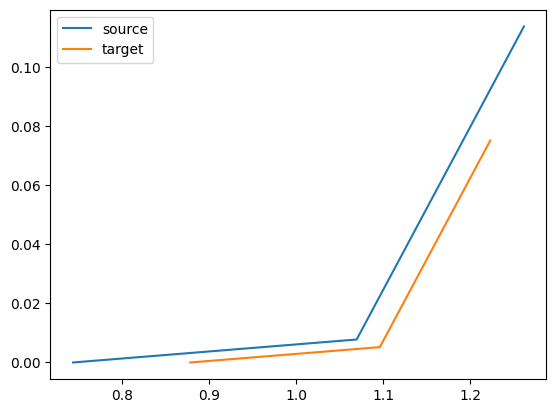

In [68]:
F2_plot(meta_parameter,bm_shift_y, bm_shift)

In [67]:
import numpy as np
import matplotlib.pyplot as plt
def F2_plot(meta_parameter,source , target):
    n = meta_parameter['number of agents']
    K = meta_parameter['number of resources']

    S = meta_parameter['number of S scenario']
    T = meta_parameter['number of T scenario']
    
    
    for s in range(S):
        prob_res = [source[s][t]['cond_prob'] for t in range(T)]
        value_res = [source[s]['r_s'] + source[s][t]['r_t'] for t in range(T)]
        sort_id_res = np.argsort(value_res).astype(int)
        short_fall_res = [sum(prob_res[tt]*max(0,value_res[t]-value_res[tt]) for tt in range(T)) for t in sort_id_res]
        value_res = [value_res[i] for i in sort_id_res]

        prob_target = [target[s][t]['cond_prob'] for t in range(T)]
        value_target = [target[s]['r_s'] + target[s][t]['r_t'] for t in range(T)]
        sort_id_target = np.argsort(value_target).astype(int)
        short_fall_target = [sum(prob_res[tt]*max(0,value_target[t]-value_target[tt]) for tt in range(T)) for t in sort_id_target]
        value_target = [value_target[i] for i in sort_id_target]
        

        x_min = min(value_target+value_res) - 0.1
        x_max = max(value_res+value_target) + 0.1
        plt.figure()
        plt.plot(value_res, short_fall_res, color='tab:blue',label='source') #benchmark
        plt.plot(value_target, short_fall_target, color='tab:orange',label='target')
        plt.legend()